## Successfully reproduce fig. 3 with sy

### This is the code kindly shared by J. Self, first author of the paper:
#### Self, J.; Bergstrom, H. K. Hypoeutectic Liquid-Solid Phase Diagrams for Ternary Lithium-Ion Battery Electrolytes. Journal of Physical Chemistry Letters 2024, 15 (2), 416-421, Article. DOI: 10.1021/acs.jpclett.3c03169.


In [1]:
# Simplified code for JPCL paper (draft) for Ruihe Li - JS 2024-02-13
import numpy as np, matplotlib.pyplot as plt, pandas as pd, scipy
import sympy as sy; from sympy import symbols,diff
from scipy import stats,integrate
plt.rc('font', size=14)
import pandas

In [2]:
###### 1) global variables ######
#################################
T0EC,T0EMC,R=273.15+38.05,273.15+-53.8,8.31
m_bar_EC,m_bar_EMC=0.088,0.104
HfusEC,HfusEMC=13020,11240 # J/mol (ding) # J/mol (ding)
#### Fitted ####
para_EC_EMC_salt = [2.7936, -7.8747, 1.7636] 
######numerical variables####
nopoints=200000
###### functions #########
def diff_central(a, b):   # self defined function to do differential
    xdc0,xdc1,xdc2 = a[:-2],a[1:-1],a[2:]
    ydc0,ydc1,ydc2 = b[:-2],b[1:-1],b[2:]
    fdc = (xdc2 - xdc1)/(xdc2 - xdc0)
    return (1-fdc)*(ydc2 - ydc1)/(xdc2 - xdc1) + fdc*(ydc1 - ydc0)/(xdc1 - xdc0)
#############

In [3]:
######## 2) Activities of EC ##########################
######################## EC - LiPF6 ###########################
def a32(xx_exp,m_e, para_i_salt ): # Eq. (2)
    [c_i_salt,d_i_salt,e_i_salt,f_i_salt] = para_i_salt
    temp=(
        (1-(2*m_e)/(2*m_e+1/m_bar_EC)) * 
        xx_exp(
            c_i_salt*m_e**1.5 + 
            d_i_salt*m_e**2  + 
            e_i_salt*m_e**2.5 + 
            f_i_salt*m_e**3))
    return(temp)
########################### EC - EMC ##########################
def a31(xx_exp,X1,para_i_j): # i=EC, j=EMC     Eq. (3)
    [c_i_j,d_i_j,e_i_j] = para_i_j
    temp=(1-X1)*xx_exp(
        c_i_j*X1**2 + 
        d_i_j*X1**3 + 
        e_i_j*X1**4)
    return(temp)

########### 3)  Fitting Activities of EMC ###################
####################### EMC - LiPF6 $########################
def a12(xx_exp,m_e,para_i_salt): # Eq. (2)
    [c_i_salt,d_i_salt,e_i_salt,f_i_salt] = para_i_salt
    temp=(
        (1-(2*m_e)/(2*m_e+1/m_bar_EMC)) *
        xx_exp(
            c_i_salt*m_e**1.5 + 
            d_i_salt*m_e**2  + 
            e_i_salt*m_e**2.5 + 
            f_i_salt*m_e**3))
    return(temp)
################################## parametrized ##################################
def a13(xx_exp,X1,para_i_j): # i=EMC j=EC     Eq. (3)
    [c_i_j,d_i_j,e_i_j] = para_i_j
    temp=(1-X1)*xx_exp(
        c_i_j*X1**2  +  
        d_i_j*X1**3  + 
        e_i_j*X1**4   ) #three suffix Margules
    return(temp)

In [4]:
################################################################
########### 4) Establishing mixing rules #######################
################################################################
########### binary global parameters ###########################
para_EC_EMC  = [-0.66992, 4.2840,   -2.5671,   ]
para_EMC_EC  = [0.62190, 2.5617,   -2.5672,    ]
para_EC_salt = [0.042895, -0.38832, 0.0663, -0.017291]

para_EMC_salt = [0.82629, -1.7913, 1.7011, -0.63441]

###############   Eq. (7)  #############################
def Fun_a_EC_simplified(xx_exp,m_e,X_EMC,para_i_j_salt,X3=0,alpha=0): # aEC 
    [c_i_j_salt,d_i_j_salt,e_i_j_salt] = para_i_j_salt
    X_EMC_apo=X_EMC/(X_EMC+X_EMC*alpha)
    X_EC_apo=X_EMC*alpha
    # X2=1-X_EMC-X_EC_apo
    first_term  =X_EC_apo
    second_term =a32(xx_exp,m_e,para_EC_salt)/(1-(2*m_e)/(2*m_e+1/m_bar_EC))
    third_term  =a31(xx_exp,X_EMC_apo,para_EC_EMC) / (1-X_EMC_apo)
    fourth_term =xx_exp(
        c_i_j_salt*m_e**1.5*X_EMC_apo**2 + 
        d_i_j_salt*m_e**1.5*X_EMC_apo**3 + 
        e_i_j_salt*m_e**2*X_EMC_apo**2  )
    ai_tern = first_term*second_term*third_term*fourth_term
    return(ai_tern)#
def Fun_a_EMC_simplified(xx_exp,m_e,X_EC,alpha=0): # aEMC 
    # X_EMC_apo=X_EC*alpha/(X_EC*alpha+X_EC) # Self version
    X_EC_apo=X_EC/(X_EC*alpha+X_EC)   # actually it is X_EC_apo
    # X_EMC_apo=X_EC/(alpha+1E-16)/(X_EC*alpha+X_EC)
    X_EMC =X_EC/(alpha+1E-16)
    # X2=1-X3-X1test
    first_term=X_EMC
    second_term = a13(xx_exp,X_EC_apo,para_EMC_EC)/(1-X_EC_apo) 
    third_term  = a12(xx_exp,m_e,para_EMC_salt) / (
        1-  (2*m_e)/(2*m_e+1/m_bar_EMC))
    ai_tern = first_term*second_term*third_term
    return(ai_tern)

In [5]:
# alpha is the mole ratio between EC:EMC  -> m_EC/m_EMC = alpha

In [6]:
####  TD Factor function (eq 10) ####
def calculatedTDfactor(xx_log,xx_exp,m_e,alpha=1):
    #nopoints=10000
    #y_e=np.linspace(0,0.1,nopoints)
    m_EC=1/(m_bar_EC+m_bar_EMC/alpha)
    m_EMC=m_EC/alpha
    # m_e=(m_EC+m_EMC)*y_e/(1-2*y_e) # m_EC+m_EMC, this is a list!
    X_EMC=m_EMC/(m_EMC+m_EC+2*m_e)
    X_EC=m_EC/(m_EC+m_EMC+2*m_e)
    aEC=Fun_a_EC_simplified(xx_exp,m_e,X_EMC,para_EC_EMC_salt,alpha=alpha)
    aEMC=Fun_a_EMC_simplified(xx_exp,m_e,X_EC,alpha=alpha)
    tempGD = (
        - 0.5* m_EMC * xx_log(aEMC[:] / aEMC[0]) 
        - 0.5* m_EC  * xx_log(aEC[:]  / aEC[0] ) 
        )
    calculatedTDfactorRETURN=diff_central(m_e[4:],tempGD[:-4])
    return(calculatedTDfactorRETURN,tempGD,aEC,aEMC)

def calculatedTDF_sy(xx_log,xx_exp,m_e,alpha=1):
    # nopoints=100000
    # y_e=np.linspace(0,0.1,nopoints)
    m_EC=1/(m_bar_EC+m_bar_EMC/alpha)
    m_EMC=m_EC/alpha
    # m_e=(m_EC+m_EMC)*y_e/(1-2*y_e) # m_EC+m_EMC
    X_EMC=m_EMC/(m_EMC+m_EC+2*m_e)
    X_EC=m_EC/(m_EC+m_EMC+2*m_e)
    X_EMC_0=m_EMC/(m_EMC+m_EC+2*0)
    X_EC_0=m_EC/(m_EC+m_EMC+2*0)
    aEC=Fun_a_EC_simplified(xx_exp,m_e,X_EMC,para_EC_EMC_salt,alpha=alpha)
    aEC_0=Fun_a_EC_simplified(xx_exp,0,X_EMC_0,para_EC_EMC_salt,alpha=alpha)
    aEMC=Fun_a_EMC_simplified(xx_exp,m_e,X_EC,alpha=alpha)
    aEMC_0=Fun_a_EMC_simplified(xx_exp,0,X_EC_0,alpha=alpha)
    Integral = (
        - 0.5* m_EMC * xx_log(aEMC / aEMC_0) 
        - 0.5* m_EC  * xx_log(aEC / aEC_0 ) 
        )
    return Integral,aEC,aEMC,aEC_0,aEMC_0

nopoints=10000
# y_e=np.linspace(0,0.1,nopoints)
m_e_List =  np.linspace(0.0,1.31,nopoints)
TDF_Self,Integral_List_Self,aEC_Self,aEMC_Self = calculatedTDfactor(
    np.log,np.exp,m_e_List,alpha=1.18)

Integral_Li = []; aEC_Li = []; aEMC_Li = []
for m_e in m_e_List:
    Integral,aEC,aEMC,aEC_0,aEMC_0 = calculatedTDF_sy(sy.log,sy.exp,m_e,alpha=1.18)
    Integral_Li.append(Integral) 
    aEC_Li.append(aEC)
    aEMC_Li.append(aEMC)


In [ ]:
def calculatedTDF_sy(xx_log,xx_exp,m_e,alpha=1):
    # nopoints=100000
    # y_e=np.linspace(0,0.1,nopoints)
    m_EC=1/(m_bar_EC+m_bar_EMC/alpha)
    m_EMC=m_EC/alpha
    # m_e=(m_EC+m_EMC)*y_e/(1-2*y_e) # m_EC+m_EMC
    X_EMC=m_EMC/(m_EMC+m_EC+2*m_e)
    X_EC=m_EC/(m_EC+m_EMC+2*m_e)
    X_EMC_0=m_EMC/(m_EMC+m_EC+2*0)
    X_EC_0=m_EC/(m_EC+m_EMC+2*0)
    aEC=Fun_a_EC_simplified(xx_exp,m_e,X_EMC,para_EC_EMC_salt,alpha=alpha)
    aEC_0=Fun_a_EC_simplified(xx_exp,0,X_EMC_0,para_EC_EMC_salt,alpha=alpha)
    aEMC=Fun_a_EMC_simplified(xx_exp,m_e,X_EC,alpha=alpha)
    aEMC_0=Fun_a_EMC_simplified(xx_exp,0,X_EC_0,alpha=alpha)
    Integral = (
        - 0.5* m_EMC * xx_log(aEMC / aEMC_0) 
        - 0.5* m_EC  * xx_log(aEC / aEC_0 ) 
        )
    return Integral

In [7]:
# sy.diff
x=symbols("x",real=True)
Integral,aEC,aEMC,aEC_0,aEMC_0 = calculatedTDF_sy(sy.log,sy.exp,x,alpha=1.18)
TDF_Salt_sy = diff(Integral,x)
TDF_Salt_Li = []
for m_e in m_e_List:
    TDF_Salt_Li.append(TDF_Salt_sy.subs({x:m_e}))


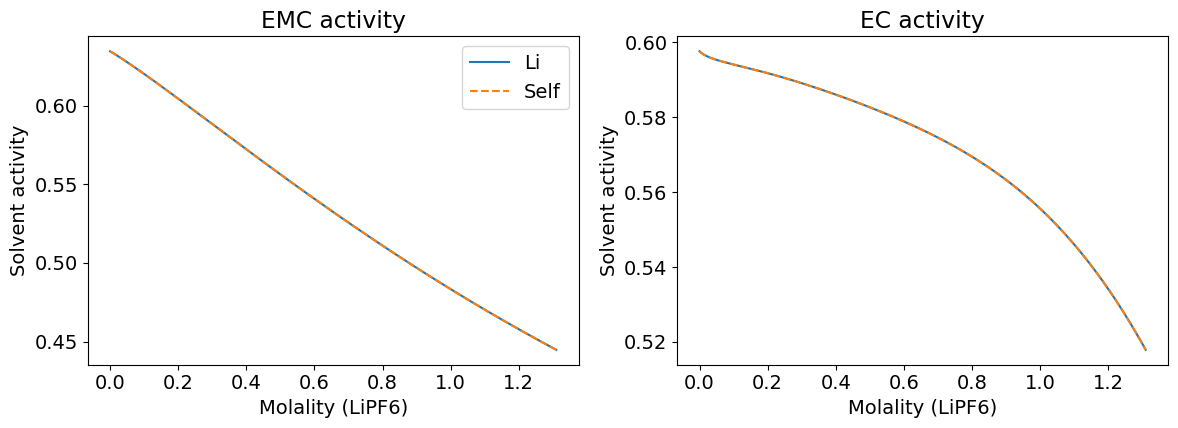

In [14]:
# plot activity
# Plot:
fig, axs = plt.subplots(1,2, figsize=(12,4.5),tight_layout=True)
axs[0].plot(m_e_List,aEC_Li,"-",label="Li")
axs[0].plot(m_e_List,aEC_Self,"--",label="Self")

axs[0].legend()
axs[1].plot(m_e_List,aEMC_Li,"-")
axs[1].plot(m_e_List,aEMC_Self,"--")


axs[0].set_title("EMC activity")
axs[1].set_title("EC activity")
for i in range(2):
    axs[i].set_ylabel("Solvent activity")
    axs[i].set_xlabel("Molality (LiPF6)")

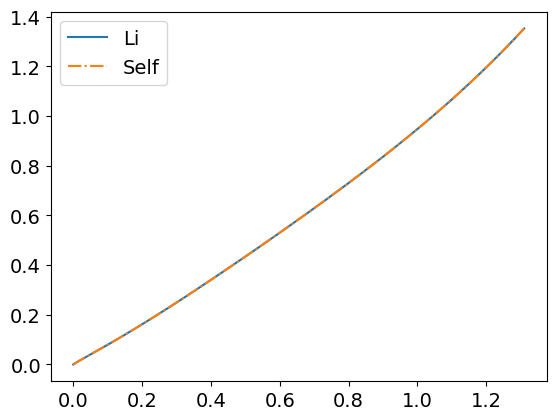

In [9]:
plt.plot(m_e_List,Integral_Li,"-",label="Li")
plt.plot(m_e_List,Integral_List_Self,"-.",label="Self")
plt.legend()

In [11]:
print(m_e_List[0],TDF_Salt_Li[0])

0.0 1.00000000000000


(-0.5, 4.0)

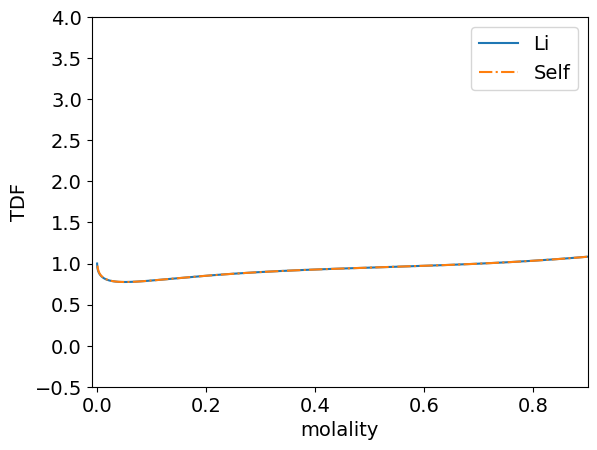

In [16]:
plt.plot(m_e_List,TDF_Salt_Li,'-',label="Li")
plt.plot(m_e_List[6:],TDF_Self,'-.',label="Self")
plt.xlabel("molality")
plt.ylabel("TDF")
plt.legend()
plt.xlim(-0.01,0.9)
plt.ylim(-0.5,4)